In [1]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy as sp
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('../../raw/LiChuan/trainSaleDate.csv')
test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [17]:
# # 热力散点图
# train = train[['sale_quantity', 'how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','total_quality_max','total_quality_mean','total_quality_min', 'month', 'year']]
# k = 10 #number of variables for heatmap
# corrmat = train.corr()
# cols = corrmat.nlargest(k, 'sale_quantity')['sale_quantity'].index
# cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [18]:
# 处理训练集和验证集,便于后面训练
train.drop_duplicates(inplace=True)
labels = train.sale_quantity.values
labels = np.log1p(labels) # 将销量进行正则化处理
train = train.drop(['class_id','sale_quantity'], axis=1)

train_test = pd.concat([train, test]).reset_index(drop=True)
month_dummies = pd.get_dummies(train_test['month'], prefix='month')
train_test = pd.concat([train_test, month_dummies], axis=1)
train_test = train_test.drop(['year', 'month'], axis=1)
train_test.fillna(0.0, inplace=True)

In [5]:
# train = train_test[0:8120]
# test = train_test[8120:]

In [6]:
# train = train[['how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','total_quality_max','total_quality_mean','total_quality_min']]
# test = test[['how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year','sale_quantity_total_last_month','sale_quantity_total_last_year','this_month_sale_class_count','total_quality_max','total_quality_mean','total_quality_min']]

In [19]:
train_test = train_test[['how_many_month_has_sell', 'sale_quantity_this_last_month','sale_quantity_this_last_year']]

In [20]:
# Skewed features
numeric_feats = train_test.dtypes[train_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
sale_quantity_this_last_mouth,4.155790
sale_quantity_this_last_year,3.347903
how_many_mouth_has_sell,0.841680


In [21]:
# Box Cox Transformation of (highly) skewed features
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train_test[feat] = boxcox1p(train_test[feat], lam)

There are 3 skewed numerical features to Box Cox transform


In [22]:
train_test = pd.get_dummies(train_test)
print(train_test.shape)

(8260, 3)


In [23]:
train = train_test[0:8120]
test = train_test[8120:]
y_train = labels

In [24]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [13]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [14]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [15]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [16]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [17]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [25]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Base models scores

In [19]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6391 (0.0934)



In [20]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.6391 (0.0933)



In [21]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.4742 (0.0862)



In [22]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.3578 (0.0667)



In [23]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.3539 (0.0653)



In [26]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.3466 (0.0588)



In [27]:
## Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [28]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.329557369504


## Stacking models

In [25]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [26]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.3506 (0.0633)


In [27]:
## Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [28]:
# StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.267899355748


In [29]:
# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.292693791168


In [30]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.329557369504


In [31]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.50 +
               xgb_train_pred*0.25 + lgb_train_pred*0.25 ))

RMSLE score on train data:
0.283004225334


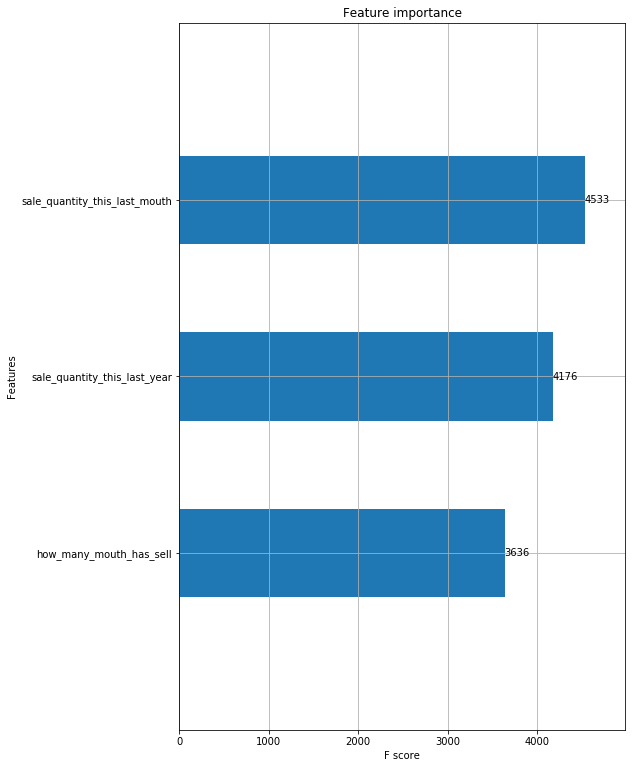

In [32]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model_xgb, max_num_features=10, height=0.5, ax=ax)

In [33]:
# Ensemble prediction
ensemble1 = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [34]:
ensemble2 = stacked_pred*0.5 + xgb_pred*0.25 + lgb_pred*0.25

In [35]:
# Submission1
submit['predict_quantity'] = ensemble1
submit.to_csv('../../raw/LiChuan/result_20180205_ensemble1.csv',index=False, header=True)  

In [36]:
# Submission2
submit['predict_quantity'] = ensemble2
submit.to_csv('../../raw/LiChuan/result_20180205_ensemble2.csv',index=False, header=True)  

### 加入原有全特征 XGBoost , RMSE = 141 模型做融合

In [7]:
result_141 = pd.read_csv('../../raw/Submissions/result_20180201.csv')

In [38]:
# Submission3-0206LiChuan
# submit['predict_quantity'] = (result_141['predict_quantity'] + ensemble2) / 2
# submit.to_csv('../../raw/LiChuan/result_20180205_ensemble_141.csv',index=False, header=True) 

### 将 RMSE = 141 和 Baseline 融合试试

In [4]:
baseline = pd.read_csv('../../raw/Submissions/result_201710.csv')

In [8]:
# Submission result_20180206_baseline_141.csv
submit['predict_quantity'] = result_141['predict_quantity'] * 0.75 + baseline['predict_quantity'] * 0.25 * 1.1
submit.to_csv('../../raw/LiChuan/result_20180206_baseline*0.25*1.1_141*0.75.csv',index=False, header=True) 

### Baseline * 1.1 试试

In [5]:
submit['predict_quantity'] = baseline['predict_quantity'] * 1.1
submit.to_csv('../../raw/LiChuan/result_20180207_baseline*1.1.csv',index=False, header=True) 